## <font color=blue>Contents</font>

1. <font color=blue>Import the packages
2. Load the data
3. Subsetting the datasets with the numeric columns and the State
4. One-hot encoded for States
5. Standardizing the numeric columns
6. MultiOutput Regressor Models</font>
    - <font color=green>6.1 Model 1: MultiOutput Regressor model for all 4 datasets - Random Forest
    - 6.2 Model 2: MultiOutput Regressor model for all 4 datasets - Ridge</font>
7. <font color=blue>Linear Regression Model 
    - 7.1 Adding a constant and Train Test split of the datasets 
    - 7.2 Model 3: OLS Model and their evaluation on 4 datasets
    - 7.3 Model 4: Random Forest Regressor Model
    - 7.4 Random Forest Model to predict the future 10 years emissions
8. Model Comparison: Random Forest Model on all the 4 datasets
9. Model Comparison: Multi output regressor on all the 4 datasets</font>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

import math

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Ridge


In [2]:

df_de =pd.read_excel('../data/data_for_training_preprocessing.xlsx',sheet_name='sheet3',index_col=0, engine='openpyxl')
df_oog =pd.read_excel('../data/data_for_training_preprocessing.xlsx',sheet_name='sheet4',index_col=0, engine='openpyxl')
df_sf6 =pd.read_excel('../data/data_for_training_preprocessing.xlsx',sheet_name='sheet5',index_col=0, engine='openpyxl')
df_ldc =pd.read_excel('../data/data_for_training_preprocessing.xlsx',sheet_name='sheet6',index_col=0, engine='openpyxl')


In [3]:
dfs = [df_de,df_sf6,df_oog,df_ldc]
for df in dfs:
    print(df.columns)
    print(df.shape)

Index(['FRS_Id', 'Facility_Name', 'City', 'State', 'Zip Code', 'Address',
       'County', 'Latitude', 'Longitude', 'Primary_NAICS_Code', 'IT_subparts',
       'IT_sectors', '2020', '2019', '2018', '2017', '2016', '2015', '2014',
       '2013', '2012', '2011', '2020_perc_change', '2020_change_pattern',
       '2012_perc_change', 'emission_reduced_2012', '2013_perc_change',
       'emission_reduced_2013', '2014_perc_change', 'emission_reduced_2014',
       '2015_perc_change', 'emission_reduced_2015', '2016_perc_change',
       'emission_reduced_2016', '2017_perc_change', 'emission_reduced_2017',
       '2018_perc_change', 'emission_reduced_2018', '2019_perc_change',
       'emission_reduced_2019', 'emission_reduced_2020'],
      dtype='object')
(6515, 41)
Index(['FRD_id', 'Facility_Name', 'City', 'State', 'Zip_Code', 'Address',
       'County', 'Latitude', 'Longitude', 'Primary_NAICS_Code', 'IT_subparts',
       '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012',
   

# Subsetting the datasets with the numeric columns and the State

In [4]:
columns = ['State','Latitude', 'Longitude','2020','2019', '2018', '2017', '2016', '2015', '2014',
       '2013', '2012', '2011']
df_de_X = df_de[columns]
df_sf6_X = df_sf6[columns]
df_oog_X = df_oog[columns]
df_ldc_X = df_ldc[columns]
df_de_X.reset_index(drop=True,inplace=True)
df_sf6_X.reset_index(drop=True,inplace=True)
df_oog_X.reset_index(drop=True,inplace=True)
df_ldc_X.reset_index(drop=True,inplace=True)

# One-hot encoded for States

In [5]:
df_de_st_dummies=pd.get_dummies(df_de_X['State'])
df_de_X_d= df_de_X.drop(['State','2020'],axis=1).join(df_de_st_dummies)
columns = df_de_X_d.columns
df_de_y=df_de_X[['2020']]
df_sf6_st_dummies=pd.get_dummies(df_sf6_X['State'])
df_sf6_X_d = df_sf6_X.drop(['State','2020'],axis=1).join(df_sf6_st_dummies)
df_sf6_y=df_sf6_X[['2020']]
df_oog_st_dummies=pd.get_dummies(df_oog_X['State'])
df_oog_X_d = df_oog_X.drop(['State','2020'],axis=1).join(df_oog_st_dummies)
df_oog_y=df_oog_X[['2020']]
df_ldc_st_dummies=pd.get_dummies(df_ldc_X['State'])
df_ldc_X_d= df_ldc_X.drop(['State','2020'],axis=1).join(df_ldc_st_dummies)
df_ldc_y=df_ldc_X[['2020']]


# Standardizing the numeric columns

In [6]:
scaler = preprocessing.StandardScaler().fit(df_de_X_d)
df_de_X_s=pd.DataFrame(scaler.transform(df_de_X_d))
df_de_X_s.columns = df_de_X_d.columns
scaler = preprocessing.StandardScaler().fit(df_sf6_X_d)
df_sf6_X_s=pd.DataFrame(scaler.transform(df_sf6_X_d))
df_sf6_X_s.columns = df_sf6_X_d.columns
scaler = preprocessing.StandardScaler().fit(df_oog_X_d)
df_oog_X_s=pd.DataFrame(scaler.transform(df_oog_X_d))
df_oog_X_s.columns = df_oog_X_d.columns
scaler = preprocessing.StandardScaler().fit(df_ldc_X_d)
df_ldc_X_s=pd.DataFrame(scaler.transform(df_ldc_X_d))
df_ldc_X_s.columns = df_ldc_X_d.columns

# Model 1: MultiOutput Regressor - Random Forest

In [7]:
#Creating the model for DE dataset

#Dropping the 3 years data to enable prediction for 3 years
X = df_de_X.drop(['State','2018','2019','2020'],axis=1).join(pd.get_dummies(df_de_X.State))
y= df_de_X[['2018','2019','2020']]

#Splitting data into training and test sets
df_de_X_train, df_de_X_test, df_de_y_train, df_de_y_test=train_test_split(X, y, test_size = 0.25, random_state = 246)

#Defining the MultiOutputRegressor
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=10, max_depth=5, random_state=2))
regr_multirf.fit(df_de_X_train, df_de_y_train)

#Predicting for 3 years
y_multirf = regr_multirf.predict(df_de_X_test)


In [8]:
print('Mean squared error', mean_squared_error(df_de_y_test, y_multirf))
print('SQRT of R-squared', math.sqrt(mean_squared_error(df_de_y_test, y_multirf)))
print('Mean absolute error', mean_absolute_error(df_de_y_test, y_multirf))


rmse=np.sqrt(np.sum((y_multirf - df_de_y_test)**2)/len(df_de_y_test))
mae = np.sum(np.abs(y_multirf - df_de_y_test))/len(df_de_y_test)
den =np.sum((df_de_y_test-np.mean(df_de_y_test))**2)/len(df_de_y_test)
print('R-squared error for DE dataset:\n',1-(rmse/den))

Mean squared error 134179107608.71758
SQRT of R-squared 366304.6650108589
Mean absolute error 115680.81348233084
R-squared error for DE dataset:
 2018    1.0
2019    1.0
2020    1.0
dtype: float64


## MultiOutput Regressor model for all 4 datasets - Random Forest

In [9]:
Xs = [df_de_X,df_sf6_X,df_oog_X,df_ldc_X]
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=10, max_depth=5, random_state=2))
y_multirf=[]
for df in Xs:
    X = df.drop(['State','2018','2019','2020'],axis=1).join(pd.get_dummies(df.State))
    y= df[['2018','2019','2020']]
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size = 0.25, random_state = 246)
    regr_multirf.fit(X_train, y_train)
    y_multirf=regr_multirf.predict(X_test)
    
    rmse=np.sqrt(np.sum((y_multirf - y_test)**2)/len(y_test))
    mae = np.sum(np.abs(y_multirf - y_test))/len(y_test)
    den =np.sum((y_test-np.mean(y_test))**2)/len(y_test)
    print('R-squared error for dataset:\n',1-(rmse/den))

R-squared error for dataset:
 2018    1.0
2019    1.0
2020    1.0
dtype: float64
R-squared error for dataset:
 2018    0.999990
2019    0.999991
2020    0.999988
dtype: float64
R-squared error for dataset:
 2018    0.999998
2019    0.999998
2020    0.999996
dtype: float64
R-squared error for dataset:
 2018    0.999992
2019    0.999989
2020    0.999989
dtype: float64


## MultiOutput Regressor model for all 4 datasets - Ridge

In [10]:
Xs = [df_de_X,df_sf6_X,df_oog_X,df_ldc_X]
regr_multiridge = MultiOutputRegressor(Ridge(normalize=True))
y_multirf=[]
for df in Xs:
    X = df.drop(['State','2018','2019','2020'],axis=1).join(pd.get_dummies(df.State))
    y= df[['2018','2019','2020']]
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size = 0.25, random_state = 246)
    regr_multiridge.fit(X_train, y_train)
    y_multiridge=regr_multiridge.predict(X_test)
    
    rmse=np.sqrt(np.sum((y_multiridge - y_test)**2)/len(y_test))
    mae = np.sum(np.abs(y_multiridge - y_test))/len(y_test)
    den =np.sum((y_test-np.mean(y_test))**2)/len(y_test)
    print('R-squared error for dataset:\n',1-(rmse/den))


R-squared error for dataset:
 2018    1.0
2019    1.0
2020    1.0
dtype: float64
R-squared error for dataset:
 2018    0.999994
2019    0.999993
2020    0.999990
dtype: float64
R-squared error for dataset:
 2018    0.999998
2019    0.999998
2020    0.999997
dtype: float64
R-squared error for dataset:
 2018    0.999989
2019    0.999987
2020    0.999984
dtype: float64


C:\Users\Radhai\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Radhai\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skl

# Adding a constant and Train Test split of the datasets for a Linear Regression Model

In [11]:
df_de_X_s1 = sm.add_constant(df_de_X_s)
df_sf6_X_s1 = sm.add_constant(df_sf6_X_s)
df_oog_X_s1 = sm.add_constant(df_oog_X_s)
df_ldc_X_s1 = sm.add_constant(df_ldc_X_s)

df_de_X_train, df_de_X_test, df_de_y_train, df_de_y_test=train_test_split(df_de_X_s1, df_de_y, test_size = 0.25, random_state = 246)
df_sf6_X_train, df_sf6_X_test, df_sf6_y_train, df_sf6_y_test=train_test_split(df_sf6_X_s1, df_sf6_y, test_size = 0.25, random_state = 246)
df_oog_X_train, df_oog_X_test, df_oog_y_train, df_oog_y_test=train_test_split(df_oog_X_s1, df_oog_y, test_size = 0.25, random_state = 246)
df_ldc_X_train, df_ldc_X_test, df_ldc_y_train, df_ldc_y_test=train_test_split(df_ldc_X_s1, df_ldc_y, test_size = 0.25, random_state = 246)


## OLS Model and their evaluation on 4 datasets

In [12]:
rModel_de = sm.OLS(df_de_y_train, df_de_X_train)
rModel_de_results = rModel_de.fit()
print(rModel_de_results.summary())
rModel_pred = rModel_de_results.predict(df_de_X_test)

                            OLS Regression Results                            
Dep. Variable:                   2020   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     1645.
Date:                Mon, 27 Jun 2022   Prob (F-statistic):               0.00
Time:                        18:38:50   Log-Likelihood:                -67023.
No. Observations:                4886   AIC:                         1.342e+05
Df Residuals:                    4821   BIC:                         1.346e+05
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.728e+05   3165.356    117.768      0.0

### The R-squared value of .956 determines that model is working with this Direct Emission data. 

In [13]:
rModel_sf6 = sm.OLS(df_sf6_y_train, df_sf6_X_train)
rModel_sf6_results = rModel_sf6.fit()
rModel_sf6_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   2020   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     2.751
Date:                Mon, 27 Jun 2022   Prob (F-statistic):            0.00457
Time:                        18:38:50   Log-Likelihood:                -724.60
No. Observations:                  66   AIC:                             1531.
Df Residuals:                      25   BIC:                             1621.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.77e+04   4342.707      6.379      0.000    1.88e+04    3.66e+04
Latitude    6053.6565   2.02e+04      0.300      0.767   -3.55e+04    4.76e+04
Longitude   3.447e+04   4.08e+04      0.845      0.406   -4.95e+04    1.18e+05
2019         2.44e+04   1.28e+04      1.913      0.067   -1869.999    5.07e+04
2018       -9947.6394   9601.278     -1.036      0.310   -2.97e+04    9826.563
2017        2.473e+04   1.46e+04      1.698      0.102   -5274.817    5.47e+04
2016        4.182e+04   2.82e+04      1.485      0.150   -1.62e+04    9.98e+04
2015        4810.5649   1.92e+04      0.251      0.804   -3.47e+04    4.44e+04
2014       -1.129e+04   1.42e+04     -0.794      0.434   -4.06e+04     1.8e+04
2013          73.3121   1.83e+04      0.004      0.997   -3.76e+04    3.78e+04
2012       -2.587e+04   1.92e+04     -1.347      0.190   -6.54e+04    1.37e+04
2011        1.603e+04   2.59e+04      0.618      0.542   -3.74e+04    6.95e+04
AL         -4215.5720   3378.185     -1.248      0.224   -1.12e+04    2741.931
AZ          7955.2734   1.07e+04      0.746      0.462    -1.4e+04    2.99e+04
CA          1.789e+04   1.94e+04      0.920      0.366   -2.21e+04    5.79e+04
CO         -2952.9350    462.934     -6.379      0.000   -3906.366   -1999.504
FL         -4197.1367   6667.425     -0.629      0.535   -1.79e+04    9534.683
GA          -565.9265   4057.199     -0.139      0.890   -8921.885    7790.032
HI          1.579e+04   1.93e+04      0.817      0.421    -2.4e+04    5.56e+04
IA         -2927.9608   3942.747     -0.743      0.465    -1.1e+04    5192.279
IL          3938.4277   5288.806      0.745      0.463   -6954.072    1.48e+04
IN         -6910.4054   5531.425     -1.249      0.223   -1.83e+04    4481.779
KS         -2952.9350    462.934     -6.379      0.000   -3906.366   -1999.504
KY         -2167.5135   4885.951     -0.444      0.661   -1.22e+04    7895.290
LA          -2.08e+04   1.52e+04     -1.369      0.183   -5.21e+04    1.05e+04
MA         -6730.8310   7783.173     -0.865      0.395   -2.28e+04    9298.913
MI         -3903.4226   9006.778     -0.433      0.668   -2.25e+04    1.46e+04
MN          4632.3150   7102.710      0.652      0.520   -9995.991    1.93e+04
MO         -1970.1981   2873.577     -0.686      0.499   -7888.441    3948.045
NC         -2952.9350    462.934     -6.379      0.000   -3906.366   -1999.504
ND         -3232.1197   5465.825     -0.591      0.560   -1.45e+04    8024.957
NE         -2952.9350    462.934     -6.379      0.000   -3906.366   -1999.504
NJ         -2952.9350    462.934     -6.379      0.000   -3906.366   -1999.504
NM          4317.7765   4215.080      1.024      0.315   -4363.344     1.3e+04
NV          7837.3412   8140.703      0.963      0.345   -8928.749    2.46e+04
NY         -7246.5068   1.54e+04     -0.472      0.641   -3.89e+04    2.44e+04
OH

### R-squared value is .851 for the SF6 dataset, which shows the possibility for improvement in the model.

In [14]:
rModel_ldc = sm.OLS(df_ldc_y_train, df_ldc_X_train)
rModel_ldc_results = rModel_ldc.fit()
rModel_ldc_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   2020   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     944.9
Date:                Mon, 27 Jun 2022   Prob (F-statistic):           1.14e-83
Time:                        18:38:50   Log-Likelihood:                -1247.1
No. Observations:                 123   AIC:                             2600.
Df Residuals:                      70   BIC:                             2749.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.751e+04    809.544     95.750      0.000    7.59e+04    7.91e+04
Latitude   -2851.2681   3789.634     -0.752      0.454   -1.04e+04    4706.919
Longitude    578.4717   7429.644      0.078      0.938   -1.42e+04    1.54e+04
2019        1.608e+05   1.81e+04      8.870      0.000    1.25e+05    1.97e+05
2018       -1.125e+04   2.46e+04     -0.456      0.649   -6.04e+04    3.79e+04
2017        1.077e+04    2.1e+04      0.512      0.610   -3.12e+04    5.27e+04
2016        2.392e+04   3.03e+04      0.789      0.433   -3.66e+04    8.44e+04
2015       -6.189e+04   2.98e+04     -2.080      0.041   -1.21e+05   -2534.734
2014        2210.6435   1.07e+04      0.206      0.837   -1.91e+04    2.36e+04
2013        1.003e+04   1.14e+04      0.880      0.382   -1.27e+04    3.27e+04
2012         1.12e+04   7115.324      1.574      0.120   -2989.932    2.54e+04
2011       -1897.5636   7129.442     -0.266      0.791   -1.61e+04    1.23e+04
AL          -555.1757   1036.182     -0.536      0.594   -2621.775    1511.424
AR          4795.5884    949.750      5.049      0.000    2901.371    6689.806
AZ            18.8965   1673.110      0.011      0.991   -3318.017    3355.810
CA           846.5516   2592.997      0.326      0.745   -4325.017    6018.120
CO          1704.2597   1357.731      1.255      0.214   -1003.650    4412.170
CT          -119.8047   2079.151     -0.058      0.954   -4266.541    4026.931
DE           175.3793   1273.092      0.138      0.891   -2363.722    2714.480
FL         -1208.5140   1518.556     -0.796      0.429   -4237.179    1820.151
GA           913.9540    721.051      1.268      0.209    -524.136    2352.044
IA           691.5308    915.744      0.755      0.453   -1134.863    2517.924
ID            90.8532   1332.683      0.068      0.946   -2567.100    2748.806
IL           172.9434    980.904      0.176      0.861   -1783.408    2129.295
IN           -84.2766    892.411     -0.094      0.925   -1864.134    1695.581
KS          -147.6672    984.680     -0.150      0.881   -2111.549    1816.215
KY           278.4362    789.142      0.353      0.725   -1295.457    1852.329
LA          -497.4949    984.926     -0.505      0.615   -2461.868    1466.878
MA           593.6672   2295.624      0.259      0.797   -3984.811    5172.146
MD             4.4132   1241.849      0.004      0.997   -2472.376    2481.202
MI           695.8636   1248.250      0.557      0.579   -1793.692    3185.419
MN          1717.2715   1317.241      1.304      0.197    -909.883    4344.426
MO           -60.5915    826.240     -0.073      0.942   -1708.476    1587.293
MS         -6071.3556     63.408    -95.750      0.000   -6197.820   -5944.891
MT           968.1465   2054.071      0.471      0.639   -3128.569    5064.862
NC            90.2269   1102.139      0.082      0.935   -2107.919    2288.373
NE

### R-squared value is .999 for the LDC dataset, the model is doing the maximum best...

In [15]:
rModel_oog = sm.OLS(df_oog_y_train, df_oog_X_train)
rModel_oog_results = rModel_oog.fit()
print(rModel_oog_results.summary())
rModel_oog_pred = rModel_oog_results.predict(df_oog_X_test)

                            OLS Regression Results                            
Dep. Variable:                   2020   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     36.84
Date:                Mon, 27 Jun 2022   Prob (F-statistic):           2.89e-82
Time:                        18:38:50   Log-Likelihood:                -4718.8
No. Observations:                 351   AIC:                             9494.
Df Residuals:                     323   BIC:                             9602.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.048e+05   9394.894     21.800      0.0

### R-squared value is .775 for the OOG dataset, the model has a lot of scope for improvement...

## Random Forest Regressor Model

RMSE for DE dataset:  359418.4770559491
MAE for DE dataset:  91493.89489457145
R-squared error for DE dataset:  0.9999997091002553


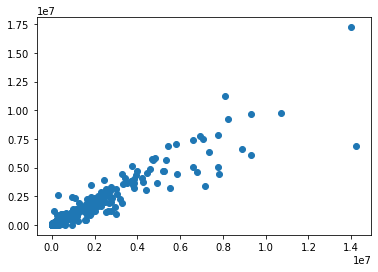

In [16]:
reg = RandomForestRegressor(n_estimators=15, random_state = 1)
de_train = np.ravel(df_de_y_train)
rModel_de_res = reg.fit(df_de_X_train, de_train)
de_pred = rModel_de_res.predict(df_de_X_test)
de_test = np.ravel(df_de_y_test)
plt.scatter(de_pred,de_test)


rmse=np.sqrt(np.sum((de_pred - de_test)**2)/len(de_pred))
print('RMSE for DE dataset: ',rmse)
mae = np.sum(np.abs(de_pred - de_test))/len(de_pred)
print('MAE for DE dataset: ',mae)
den =np.sum((de_test-np.mean(de_test))**2)/len(de_test)
print('R-squared error for DE dataset: ',1-(rmse/den))

In [17]:
print(de_pred, de_test)

[168746.95573333 134855.01652447   8762.19853333 ...  74775.85826667
  49845.467       25320.8356    ] [193378.584 196779.85    4757.974 ...  96490.8    15247.804  18881.164]


In [18]:
print(df_de_X_train)

      const  Latitude  Longitude      2019      2018      2017      2016  \
3123    1.0  0.836661   0.437383 -0.329867 -0.323500 -0.319521 -0.327774   
2688    1.0  0.962071   0.019175 -0.117024 -0.140815 -0.169167 -0.189448   
3562    1.0  0.117299  -1.768317  2.244160  2.248411  2.307499  2.236242   
5310    1.0  0.439454   1.031711 -0.343819 -0.339878 -0.338010 -0.349645   
2465    1.0  1.267203  -0.031720 -0.301842 -0.303494 -0.295831 -0.309358   
...     ...       ...        ...       ...       ...       ...       ...   
6377    1.0 -1.368603   0.184413 -0.328776 -0.320770 -0.317823 -0.327321   
4974    1.0 -0.144335   0.884266 -0.342465 -0.324443 -0.282056 -0.321177   
1668    1.0 -0.548119   0.541905 -0.055906 -0.112718 -0.160241 -0.024014   
6302    1.0 -0.426311   0.291065 -0.160995 -0.198621 -0.193887 -0.089481   
2980    1.0  0.433711   0.302151 -0.317638 -0.319813 -0.316249 -0.325022   

              2015          2014          2013  ...        TN        TX  \
3123 -3.3146

RMSE for OOG dataset:  167214.06641913997
MAE for OOG dataset:  80872.30982692259
R-squared error for OOG dataset:  0.99999716392448


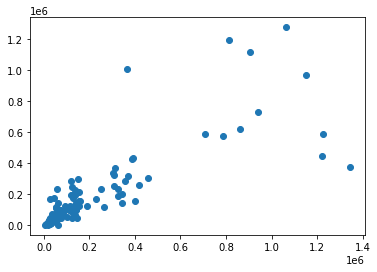

In [19]:
reg = RandomForestRegressor(n_estimators=15, random_state = 1)
y_train = np.ravel(df_oog_y_train)
model_oog_res = reg.fit(df_oog_X_train, y_train)
oog_pred = model_oog_res.predict(df_oog_X_test)
oog_test = np.ravel(df_oog_y_test)
plt.scatter(oog_pred, oog_test)

rmse=np.sqrt(np.sum((oog_pred - oog_test)**2)/len(oog_pred))
print('RMSE for OOG dataset: ',rmse)
mae = np.sum(np.abs(oog_pred - oog_test))/len(oog_pred)
print('MAE for OOG dataset: ',mae)
den =np.sum((oog_test-np.mean(oog_test))**2)/len(oog_test)
print('R-squared error for OOG dataset: ',1-(rmse/den))

RMSE for LDC dataset:  5025.030076321013
MAE for LDC dataset:  3086.2842569105683
R-squared error for LDC dataset 0.9999969348431952


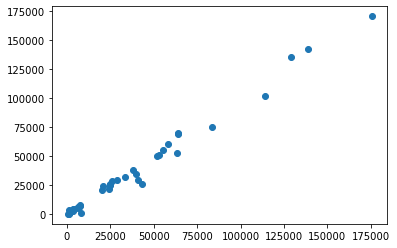

In [20]:
reg = RandomForestRegressor(n_estimators=15, random_state = 1)
ldc_train = np.ravel(df_ldc_y_train)
rModel_ldc_res = reg.fit(df_ldc_X_train, ldc_train)
ldc_pred = rModel_ldc_res.predict(df_ldc_X_test)
ldc_test = np.ravel(df_ldc_y_test)
plt.scatter(ldc_pred,ldc_test)


rmse=np.sqrt(np.sum((ldc_pred - ldc_test)**2)/len(ldc_pred))
print('RMSE for LDC dataset: ',rmse)
mae = np.sum(np.abs(ldc_pred - ldc_test))/len(ldc_pred)
print('MAE for LDC dataset: ',mae)
den =np.sum((ldc_test-np.mean(ldc_test))**2)/len(ldc_test)
print('R-squared error for LDC dataset', 1-(rmse/den))

RMSE for SF6 dataset:  37304.66170046136
MAE for SF6 dataset:  21185.232321070238
R-squared error for SF6 dataset: 0.9999878036751283


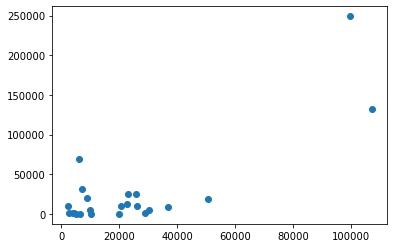

In [21]:
reg = RandomForestRegressor(n_estimators=15, random_state = 1)
sf6_train = np.ravel(df_sf6_y_train)
rModel_sf6_res = reg.fit(df_sf6_X_train, sf6_train)
sf6_pred = rModel_sf6_res.predict(df_sf6_X_test)
sf6_test = np.ravel(df_sf6_y_test)
plt.scatter(sf6_pred,sf6_test)


rmse=np.sqrt(np.sum((sf6_pred - sf6_test)**2)/len(sf6_pred))
print('RMSE for SF6 dataset: ',rmse)
mae = np.sum(np.abs(sf6_pred - sf6_test))/len(sf6_pred)
print('MAE for SF6 dataset: ',mae)
den =np.sum((sf6_test-np.mean(sf6_test))**2)/len(sf6_test)
print('R-squared error for SF6 dataset:', 1-(rmse/den))

### Random Forest Model is doing very well on all the four datasets.

## Building a Random Forest Model to predict the future 10 years emission

RMSE for DE dataset:  116499.0729368651
MAE for DE dataset:  28730.47531361095
R-squared error for DE dataset:  0.9999998971832522


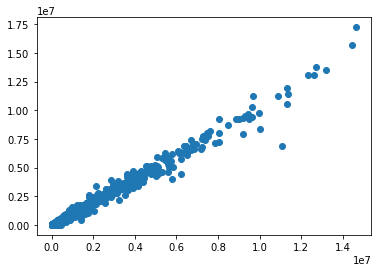

In [22]:
reg = RandomForestRegressor(n_estimators=15, random_state = 1)

de_train = np.ravel(df_de_y)
rModel_de_res = reg.fit(df_de_X_s, de_train)
de_pred = rModel_de_res.predict(df_de_X_s)
de_test = np.ravel(df_de_y)
plt.scatter(de_pred,de_test)

rmse=np.sqrt(np.sum((de_pred - de_test)**2)/len(de_pred))
print('RMSE for DE dataset: ',rmse)
mae = np.sum(np.abs(de_pred - de_test))/len(de_pred)
print('MAE for DE dataset: ',mae)
den =np.sum((de_test-np.mean(de_test))**2)/len(de_test)
print('R-squared error for DE dataset: ',1-(rmse/den))

In [23]:
years =  ['2020','2019', '2018', '2017', '2016','2015', '2014', '2013', '2012','2011']
years_future = ['2020','2021','2022','2023','2024','2025','2026','2027','2028','2029']
y_future = {}
i=9
print(X.shape, y.shape)
X1=df_de_X_s.copy()
for year in years_future:
    y_pred = rModel_de_res.predict(X1)
    #append the results to the dataframe
    X1 = X1.drop([years[-1]],axis = 1)
    X1[year] = y_pred
    years.pop(i)
    i=i-1
X1['2030'] =rModel_de_res.predict(X1)

(164, 52) (164, 3)


C:\Users\Radhai\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 2020
Feature names seen at fit time, yet now missing:
- 2011

  warnings.warn(message, FutureWarning)
C:\Users\Radhai\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 2020
- 2021
Feature names seen at fit time, yet now missing:
- 2011
- 2012

  warnings.warn(message, FutureWarning)
C:\Users\Radhai\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 2020
- 2021
- 2022
Feature names seen at fit time, yet now missing:
- 2011
- 2012
- 2013

  war

In [24]:
X1.head()

,Latitude,Longitude,AK,AL,AR,AZ,CA,CO,CT,DC,...,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
0,-0.671908,-0.242047,-0.098815,-0.164671,-0.124218,-0.117686,-0.247483,-0.132257,-0.078598,-0.024786,...,397519.728533,436117.589600,439892.066133,416371.448267,438368.814133,412113.502667,436870.510600,500750.693733,294328.890533,294328.890533
1,0.559976,1.102614,-0.098815,-0.164671,-0.124218,-0.117686,-0.247483,-0.132257,-0.078598,-0.024786,...,55771.236267,53624.354538,53728.296933,48547.499738,44669.635876,47583.883200,54118.689733,77050.832267,303727.368657,303727.368657
2,-0.798682,-0.658915,-0.098815,-0.164671,-0.124218,-0.117686,-0.247483,-0.132257,-0.078598,-0.024786,...,41421.104800,39468.723200,39468.723200,39468.723200,37926.519467,38417.360667,45561.318133,45275.415733,294124.642533,294124.642533
3,0.756044,0.272284,-0.098815,-0.164671,-0.124218,-0.117686,-0.247483,-0.132257,-0.078598,-0.024786,...,44980.744400,42805.762400,39079.832533,41091.666133,35820.244400,37049.710400,38674.512000,15249.807333,301868.933190,301868.933190
4,-0.944130,-0.388869,-0.098815,-0.164671,-0.124218,-0.117686,-0.247483,-0.132257,-0.078598,-0.024786,...,31135.200000,28231.549467,32170.732000,33343.600667,33117.882800,31684.666133,37317.278967,44062.024700,295899.694400,295899.694400


## Following the same steps for all the four data sets

In [25]:
Xs=[df_de_X_s,df_sf6_X_s,df_oog_X_s,df_ldc_X_s]
ys=[df_de_y,df_sf6_y,df_oog_y,df_ldc_y]
output=[]
for df in range(4):
    y = np.ravel(ys[df])
    X=Xs[df]
    rModel_res = reg.fit(X, y)
    y_pred = rModel_res.predict(X)
    years =  ['2020','2019', '2018', '2017', '2016','2015', '2014', '2013', '2012','2011']
    years_future = ['2020','2021','2022','2023','2024','2025','2026','2027','2028','2029']
    i=9
    X1=X.copy()
    for year in years_future:
        y_pred = rModel_res.predict(X1)
        #append the results to the dataframe
        X1 = X1.drop([years[-1]],axis = 1)
        X1[year] = y_pred
        years.pop(i)
        i=i-1
    X1['2030'] =rModel_res.predict(X1)
    output.append(X1)

C:\Users\Radhai\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 2020
Feature names seen at fit time, yet now missing:
- 2011

  warnings.warn(message, FutureWarning)
C:\Users\Radhai\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 2020
- 2021
Feature names seen at fit time, yet now missing:
- 2011
- 2012

  warnings.warn(message, FutureWarning)
C:\Users\Radhai\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 2020
- 2021
- 2022
Feature names seen at fit time, yet now missing:
- 2011
- 2012
- 2013

  war

In [26]:
de_future = output[0]
sf6_future = output[1]
oog_future = output[2]
ldc_future = output[3]


In [27]:
print(de_future, sf6_future, oog_future, ldc_future)

      Latitude  Longitude        AK        AL        AR        AZ        CA  \
0    -0.671908  -0.242047 -0.098815 -0.164671 -0.124218 -0.117686 -0.247483   
1     0.559976   1.102614 -0.098815 -0.164671 -0.124218 -0.117686 -0.247483   
2    -0.798682  -0.658915 -0.098815 -0.164671 -0.124218 -0.117686 -0.247483   
3     0.756044   0.272284 -0.098815 -0.164671 -0.124218 -0.117686 -0.247483   
4    -0.944130  -0.388869 -0.098815 -0.164671 -0.124218 -0.117686 -0.247483   
...        ...        ...       ...       ...       ...       ...       ...   
6510 -0.923351  -0.101422 -0.098815 -0.164671 -0.124218 -0.117686 -0.247483   
6511  0.863513   0.273532 -0.098815 -0.164671 -0.124218 -0.117686 -0.247483   
6512  0.405063  -0.748091 -0.098815 -0.164671 -0.124218 -0.117686 -0.247483   
6513 -1.576858  -0.286316 -0.098815 -0.164671 -0.124218 -0.117686 -0.247483   
6514 -0.276575   0.565839 -0.098815 -0.164671 -0.124218 -0.117686 -0.247483   

            CO        CT        DC  ...           2

## Building Multi output Ridge and RF regressors to predict the future 10 years emission

In [28]:
Xs = [df_de_X,df_sf6_X,df_oog_X,df_ldc_X]

regr_multioutput = MultiOutputRegressor(Ridge(normalize=True,alpha=.001))
regr_multioutput1 = MultiOutputRegressor(RandomForestRegressor(n_estimators=10, max_depth=5, random_state=2))

y_multioutput=[]
y_multioutput1=[]
multioutput=[]
multioutput1=[]

for df in Xs:
    X_temp = df.drop('State',axis=1).join(pd.get_dummies(df.State))
    X = X_temp.drop(['2019','2020'],axis=1)
    y= df[['2019','2020']]
    regr_multioutput.fit(X, y)
    regr_multioutput1.fit(X,y)
    years =  ['2020','2019', '2018', '2017', '2016','2015', '2014', '2013', '2012','2011']
    years_future = ['2019','2020','2021','2022','2023','2024','2025','2026','2027','2028']
    i=9
    j=0
 
    X1=X.copy()
    X2 = X.copy()
    for j in range(5):
        y_multioutput = regr_multioutput.predict(X1)
        y_multioutput1 = regr_multioutput1.predict(X2)

        #append the results to the dataframe
        if i>0:
            for num in range(2):
                X1 = X1.drop([years[-1]],axis = 1)
                X2 = X2.drop([years[-1]],axis = 1)

                years.pop(i)
                i=i-1
                col = years_future[0]
                
                X1[col] = y_multioutput[:,num]
                X2[col] = y_multioutput1[:,num]
                
                years_future.pop(0)
                
    y_multioutput = regr_multioutput.predict(X1)
    y_multioutput1 = regr_multioutput1.predict(X2)

    X1['2029'] = y_multioutput[:,0]
    X1['2030'] = y_multioutput[:,1]
    X2['2029'] = y_multioutput1[:,0]
    X2['2030'] = y_multioutput1[:,1]
       
    multioutput.append(X1)
    multioutput1.append(X2)

C:\Users\Radhai\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Radhai\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skl

C:\Users\Radhai\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Radhai\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skl

C:\Users\Radhai\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 2019
- 2020
- 2021
- 2022
- 2023
- ...
Feature names seen at fit time, yet now missing:
- 2011
- 2012
- 2013
- 2014
- 2015
- ...

  warnings.warn(message, FutureWarning)
C:\Users\Radhai\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 2021
- 2022
- 2023
- 2024
- 2025
- ...
Feature names seen at fit time, yet now missing:
- 2011
- 2012
- 2013
- 2014
- 2015
- ...

  warnings.warn(message, FutureWarning)
C:\Users\Radhai\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature n

# Comparison of output of different models

## SF6 2021-2030 emission prediction using Multioutput Ridge Regressor

In [29]:
df_de_pred = pd.DataFrame()
df_sf6_pred = pd.DataFrame()
df_ldc_pred = pd.DataFrame()
df_oog_pred = pd.DataFrame()

In [30]:
df_de_X.columns

Index(['State', 'Latitude', 'Longitude', '2020', '2019', '2018', '2017',
       '2016', '2015', '2014', '2013', '2012', '2011'],
      dtype='object')

In [31]:
df_de_pred['State'] = df_de_X['State']
df_de_pred['2011'] = df_de_X['2011']
df_de_pred['2020']=df_de_X['2020']
df_de_pred['2030']=de_future['2030']
df_de_pred['reduction'] = 100*(df_de_pred['2020'] - df_de_pred['2030'])/df_de_pred['2030'] 
df_oog_pred['2020']=df_oog_X['2020']
df_oog_pred['2030']=oog_future['2030']
df_sf6_pred['2020']=df_sf6_X['2020']
df_sf6_pred['2030']=sf6_future['2030']
df_ldc_pred['2020']=df_ldc_X['2020']
df_ldc_pred['2030']=ldc_future['2030']

In [32]:
df_de_pred.columns

Index(['State', '2011', '2020', '2030', 'reduction'], dtype='object')

In [33]:
df_de_g = df_de_pred.groupby('State')[['2011','2020','2030']].mean().apply(lambda x: round(x,2))

In [34]:
df_de_g['reduction']=100*(df_de_g['2020'] - df_de_g['2030'])/df_de_g['2020']
df_de_g['reduction0']=100*(df_de_g['2011'] - df_de_g['2020'])/df_de_g['2011']

In [35]:
print(df_de_g)

             2011       2020        2030    reduction  reduction0
State                                                            
AK      298925.04  227011.06  9909353.61 -4265.141333   24.057530
AL      659053.59  428724.98   280377.90    34.601921   34.948389
AR      538902.19  332116.35   472050.20   -42.133984   38.371683
AZ      539429.66  487898.79   305491.74    37.386248    9.552843
CA      300465.00  240849.09   309739.23   -28.603031   19.841216
CO      524792.27  356024.83   328417.57     7.754307   32.158904
CT      250045.63  268620.23   298566.40   -11.148144   -7.428484
DC      198014.91   59417.18   300394.41  -405.568272   69.993583
DE      425387.17  309249.64   256273.56    17.130523   27.301606
FL      804265.35  692818.77   305790.71    55.862814   13.856942
GA      560466.83  325187.36   304502.53     6.360896   41.979196
GU      545888.17  151643.55   300907.61   -98.430866   72.220766
HI      367942.81  254520.02   304525.48   -19.646965   30.826201
IA      44

In [53]:
df_de_g.reset_index()

,State,2011,2020,2030
0,AK,298925.04,227011.06,9909353.61
1,AL,659053.59,428724.98,280377.90
2,AR,538902.19,332116.35,472050.20
3,AZ,539429.66,487898.79,305491.74
4,CA,300465.00,240849.09,309739.23
5,CO,524792.27,356024.83,328417.57
6,CT,250045.63,268620.23,298566.40
7,DC,198014.91,59417.18,300394.41
8,DE,425387.17,309249.64,256273.56
9,FL,804265.35,692818.77,305790.71


In [58]:
sns.relplot(y='', x='2011', size= 3, data= df_de_g)

ValueError: Could not interpret input 'State'

In [43]:
print(df_de_pred)

     State        2020           2030   reduction           2011
0       TX  504064.000  294328.890533   71.258757  194000.000000
1       NY   60819.700  303727.368657  -79.975562  100591.828000
2       NM   40521.812  294124.642533  -86.222912  534026.861412
3       IL  100500.948  301868.933190  -66.707091   95113.250000
4       TX   29359.640  295899.694400  -90.077840   37149.360000
...    ...         ...            ...         ...            ...
6510    TX   22359.122  298636.808933  -92.512938  534026.861412
6511    IL  325679.418  302606.434523    7.624750   66811.452000
6512    CO       0.000  328617.564923 -100.000000   31193.236000
6513    TX  650907.100  295899.694400  119.975590  534026.861412
6514    NC   89476.750  305923.779333  -70.751947   38540.000000

[6515 rows x 5 columns]


KeyError: "['TX'] not in index"

In [30]:
multioutput[1]

,Latitude,Longitude,AL,AZ,CA,CO,FL,GA,HI,IA,...,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
0,39.588493,-81.682523,0,0,0,0,0,0,0,0,...,1.499692e+09,1.173622e+09,9.249814e+12,8.351947e+12,1.110577e+17,8.007865e+16,3.535317e+20,4.431790e+20,1.025839e+25,6.241449e+24
1,40.690480,-89.592440,0,0,0,0,0,0,0,0,...,8.790722e+07,6.693614e+07,4.520644e+11,4.418925e+11,7.063002e+15,4.778622e+15,7.241917e+18,2.012332e+19,7.459513e+23,4.112583e+23
2,38.620785,-90.211635,0,0,0,0,0,0,0,0,...,-2.822039e+08,-1.354664e+08,2.401329e+12,6.191379e+11,-4.631794e+16,-1.895937e+16,5.529871e+20,1.856431e+20,-8.577076e+24,-3.261008e+24
3,33.834580,-117.914010,0,0,1,0,0,0,0,0,...,-2.224387e+08,-7.099875e+07,3.628456e+12,1.406063e+12,-4.716093e+16,-1.657453e+16,6.954843e+20,2.590689e+20,-9.545946e+24,-3.444757e+24
4,33.578425,-112.104408,0,1,0,0,0,0,0,0,...,2.968880e+08,2.017880e+08,3.491451e+11,8.695319e+11,3.108099e+16,1.724494e+16,-1.516787e+20,-8.529308e+18,4.409050e+24,1.982168e+24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,31.758530,-106.485870,0,0,0,0,0,0,0,0,...,8.726585e+08,4.471374e+08,-6.055901e+12,-1.190076e+12,1.348226e+17,5.734141e+16,-1.505129e+21,-4.850932e+20,2.432482e+25,9.393996e+24
85,32.163060,-110.897450,0,1,0,0,0,0,0,0,...,-1.233751e+09,-5.448903e+08,1.279515e+13,3.921669e+12,-2.165913e+17,-8.504495e+16,2.761126e+21,9.607986e+20,-4.118358e+25,-1.541370e+25
86,43.661080,-72.992600,0,0,0,0,0,0,0,0,...,-1.129070e+07,-3.963496e+06,1.667272e+11,6.214069e+10,-2.286755e+15,-8.249179e+14,3.269214e+19,1.201664e+19,-4.565412e+23,-1.660623e+23
87,37.533948,-77.452741,0,0,0,0,0,0,0,0,...,2.846117e+08,2.390724e+08,2.548219e+12,2.004359e+12,1.621104e+16,1.445265e+16,1.856720e+20,1.356022e+20,6.746156e+23,7.851284e+23


## SF6 2021-2030 emission prediction using Multioutput Random Forest Regressor

In [31]:
multioutput[0]

,Latitude,Longitude,AK,AL,AR,AZ,CA,CO,CT,DC,...,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
0,33.298570,-96.535860,0,0,0,0,0,0,0,0,...,-8.176603e+09,4.261335e+09,-8.816312e+13,1.121368e+15,-1.922272e+19,1.184075e+20,-2.048875e+24,1.335170e+25,-2.308034e+29,1.495382e+30
1,40.663000,-74.000000,0,0,0,0,0,0,0,0,...,-1.389584e+09,3.709356e+09,-6.570283e+13,4.856864e+14,-8.378777e+18,5.364073e+19,-9.275417e+23,6.020348e+24,-1.040775e+29,6.745915e+29
2,32.540693,-103.522351,0,0,0,0,0,0,0,0,...,-5.483382e+09,1.204293e+09,-3.103083e+13,5.885505e+14,-1.005968e+19,6.084126e+19,-1.053123e+24,6.876116e+24,-1.188597e+29,7.699456e+29
3,41.835129,-87.915924,0,0,0,0,0,0,0,0,...,-6.154142e+08,5.294527e+08,-1.018195e+13,1.050344e+14,-1.804230e+18,1.125554e+19,-1.947167e+23,1.267208e+24,-2.190602e+28,1.419486e+29
4,31.671177,-98.996513,0,0,0,0,0,0,0,0,...,-1.039369e+09,1.594003e+09,-2.908653e+13,2.465758e+14,-4.245550e+18,2.686701e+19,-4.646717e+23,3.019594e+24,-5.220056e+28,3.383042e+29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6510,31.795396,-94.179048,0,0,0,0,0,0,0,0,...,-1.315164e+07,4.783804e+09,-8.130537e+13,4.740551e+14,-8.211227e+18,5.382676e+19,-9.303796e+23,6.024393e+24,-1.041517e+29,6.752344e+29
6511,42.477600,-87.895000,0,0,0,0,0,0,0,0,...,-4.865420e+09,5.311551e+09,-9.962476e+13,9.416851e+14,-1.619188e+19,1.016254e+20,-1.757893e+24,1.143310e+25,-1.976443e+29,1.280794e+30
6512,39.736900,-105.016900,0,0,0,0,0,1,0,0,...,-3.968380e+08,-4.512482e+08,6.902113e+12,-1.063288e+13,1.939633e+17,-1.642138e+18,2.827488e+22,-1.789499e+23,3.094977e+27,-2.011199e+28
6513,27.888611,-97.277778,0,0,0,0,0,0,0,0,...,-1.095557e+10,5.242843e+09,-1.101960e+14,1.456338e+15,-2.495656e+19,1.534094e+20,-2.654631e+24,1.730293e+25,-2.991051e+29,1.937868e+30


## SF6 2021-2030 emission prediction using Linear Regression Random Forest Model

In [32]:
sf6_future

,Latitude,Longitude,AL,AZ,CA,CO,FL,GA,HI,IA,...,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
0,0.377242,0.846618,-0.1066,-0.186772,-0.355784,-0.106600,-0.21693,-0.1066,-0.1066,-0.15162,...,111616.184000,92181.464000,95138.624000,95138.624000,96398.248000,90600.550974,88118.698872,30178.278769,21725.593846,21725.593846
1,0.563098,0.378405,-0.1066,-0.186772,-0.355784,-0.106600,-0.21693,-0.1066,-0.1066,-0.15162,...,9782.872000,6551.960000,6819.632000,7258.152000,22195.308923,11831.453949,15746.517949,13134.171897,23920.925949,23920.925949
2,0.214034,0.341752,-0.1066,-0.186772,-0.355784,-0.106600,-0.21693,-0.1066,-0.1066,-0.15162,...,11631.496000,9256.040000,5509.240000,5947.304000,14125.020923,13941.100923,14942.628923,16830.281846,16344.980923,16344.980923
3,-0.593181,-1.298040,-0.1066,-0.186772,2.810694,-0.106600,-0.21693,-0.1066,-0.1066,-0.15162,...,1773.992000,1741.464000,1953.200000,23620.952000,16134.192000,6934.848000,12229.920000,21038.245949,46204.012923,46204.012923
4,-0.636383,-0.954151,-0.1066,5.354126,-0.355784,-0.106600,-0.21693,-0.1066,-0.1066,-0.15162,...,25482.040000,30103.334974,40773.317949,28972.797949,23736.019897,25307.773949,28895.924923,44527.947897,76079.499897,76079.499897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,-0.943317,-0.621572,-0.1066,-0.186772,-0.355784,-0.106600,-0.21693,-0.1066,-0.1066,-0.15162,...,10190.840000,10190.840000,10223.368000,10545.038974,18660.470974,15719.688000,18846.974974,19683.968821,21940.977846,21940.977846
85,-0.875091,-0.882707,-0.1066,5.354126,-0.355784,-0.106600,-0.21693,-0.1066,-0.1066,-0.15162,...,10381.030974,19661.012923,31692.685949,20196.621949,18644.288821,19801.347897,29134.833846,43882.290872,73081.108923,73081.108923
86,1.064103,1.361002,-0.1066,-0.186772,-0.355784,-0.106600,-0.21693,-0.1066,-0.1066,-0.15162,...,969.152000,969.000000,1347.024000,1149.120000,1256.432000,1040.896000,5837.712000,7965.941949,20327.154872,20327.154872
87,0.030734,1.096992,-0.1066,-0.186772,-0.355784,-0.106600,-0.21693,-0.1066,-0.1066,-0.15162,...,44981.398974,45134.275897,44697.462974,43614.805949,42365.786872,42223.132923,26183.905846,23045.565744,21725.593846,21725.593846


## SF6 2021-2030 emission prediction using Multioutput Ridge Regressor Model


In [33]:
multioutput[0]

,Latitude,Longitude,AK,AL,AR,AZ,CA,CO,CT,DC,...,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
0,33.298570,-96.535860,0,0,0,0,0,0,0,0,...,-8.176603e+09,4.261335e+09,-8.816312e+13,1.121368e+15,-1.922272e+19,1.184075e+20,-2.048875e+24,1.335170e+25,-2.308034e+29,1.495382e+30
1,40.663000,-74.000000,0,0,0,0,0,0,0,0,...,-1.389584e+09,3.709356e+09,-6.570283e+13,4.856864e+14,-8.378777e+18,5.364073e+19,-9.275417e+23,6.020348e+24,-1.040775e+29,6.745915e+29
2,32.540693,-103.522351,0,0,0,0,0,0,0,0,...,-5.483382e+09,1.204293e+09,-3.103083e+13,5.885505e+14,-1.005968e+19,6.084126e+19,-1.053123e+24,6.876116e+24,-1.188597e+29,7.699456e+29
3,41.835129,-87.915924,0,0,0,0,0,0,0,0,...,-6.154142e+08,5.294527e+08,-1.018195e+13,1.050344e+14,-1.804230e+18,1.125554e+19,-1.947167e+23,1.267208e+24,-2.190602e+28,1.419486e+29
4,31.671177,-98.996513,0,0,0,0,0,0,0,0,...,-1.039369e+09,1.594003e+09,-2.908653e+13,2.465758e+14,-4.245550e+18,2.686701e+19,-4.646717e+23,3.019594e+24,-5.220056e+28,3.383042e+29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6510,31.795396,-94.179048,0,0,0,0,0,0,0,0,...,-1.315164e+07,4.783804e+09,-8.130537e+13,4.740551e+14,-8.211227e+18,5.382676e+19,-9.303796e+23,6.024393e+24,-1.041517e+29,6.752344e+29
6511,42.477600,-87.895000,0,0,0,0,0,0,0,0,...,-4.865420e+09,5.311551e+09,-9.962476e+13,9.416851e+14,-1.619188e+19,1.016254e+20,-1.757893e+24,1.143310e+25,-1.976443e+29,1.280794e+30
6512,39.736900,-105.016900,0,0,0,0,0,1,0,0,...,-3.968380e+08,-4.512482e+08,6.902113e+12,-1.063288e+13,1.939633e+17,-1.642138e+18,2.827488e+22,-1.789499e+23,3.094977e+27,-2.011199e+28
6513,27.888611,-97.277778,0,0,0,0,0,0,0,0,...,-1.095557e+10,5.242843e+09,-1.101960e+14,1.456338e+15,-2.495656e+19,1.534094e+20,-2.654631e+24,1.730293e+25,-2.991051e+29,1.937868e+30


## SF6 2021-2030 emission prediction using Multioutput Random Forest Regressor Model


In [34]:
multioutput1[0]

,Latitude,Longitude,AK,AL,AR,AZ,CA,CO,CT,DC,...,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
0,33.298570,-96.535860,0,0,0,0,0,0,0,0,...,641653.341274,637930.423736,641653.341274,637930.423736,780838.122438,811238.954068,35167.318453,33133.753025,35167.318453,33133.753025
1,40.663000,-74.000000,0,0,0,0,0,0,0,0,...,58805.237659,76230.954541,58805.237659,76230.954541,58805.237659,76230.954541,35167.318453,33133.753025,35167.318453,33133.753025
2,32.540693,-103.522351,0,0,0,0,0,0,0,0,...,266127.872082,135249.017285,266127.872082,135249.017285,266127.872082,135249.017285,35167.318453,33133.753025,35167.318453,33133.753025
3,41.835129,-87.915924,0,0,0,0,0,0,0,0,...,35167.318453,33133.753025,35167.318453,33133.753025,35167.318453,33133.753025,35167.318453,33133.753025,35167.318453,33133.753025
4,31.671177,-98.996513,0,0,0,0,0,0,0,0,...,35167.318453,33133.753025,35167.318453,33133.753025,35167.318453,33133.753025,35167.318453,33133.753025,35167.318453,33133.753025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6510,31.795396,-94.179048,0,0,0,0,0,0,0,0,...,35167.318453,33133.753025,35167.318453,33133.753025,35167.318453,33133.753025,35167.318453,33133.753025,35167.318453,33133.753025
6511,42.477600,-87.895000,0,0,0,0,0,0,0,0,...,293735.042463,255110.773120,293735.042463,255110.773120,293735.042463,255110.773120,35167.318453,33133.753025,35167.318453,33133.753025
6512,39.736900,-105.016900,0,0,0,0,0,1,0,0,...,35167.318453,33133.753025,35167.318453,33133.753025,35167.318453,33133.753025,35167.318453,33133.753025,35167.318453,33133.753025
6513,27.888611,-97.277778,0,0,0,0,0,0,0,0,...,815354.575959,767466.513673,815354.575959,767466.513673,815354.575959,819529.176762,35167.318453,33133.753025,35167.318453,33133.753025
